## ✈ Download Flickr8k Images and Captions ✈

In [1]:
#!wget -q https://github.com/jbrownlee/Datasets/releases/download/Flickr8k/Flickr8k_Dataset.zip
#!wget -q https://github.com/jbrownlee/Datasets/releases/download/Flickr8k/Flickr8k_text.zip
#!unzip -qq Flickr8k_Dataset.zip
#!unzip -qq Flickr8k_text.zip
#!rm Flickr8k_Dataset.zip Flickr8k_text.zip

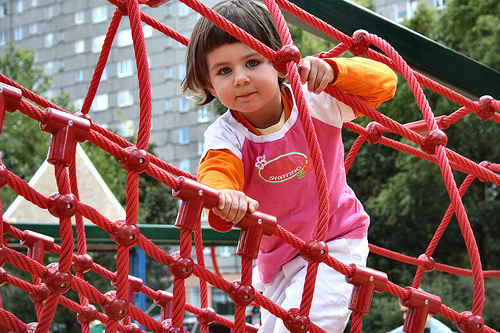

In [2]:
from PIL import Image
image = Image.open('./Flicker8k_Dataset/1007320043_627395c3d8.jpg')
display(image)

##  ⭐ Extract Photo Features With CNN ⭐


In [4]:
from keras.applications.vgg16 import VGG16
from keras import Model
from keras.applications.imagenet_utils import preprocess_input
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from os import listdir

# extract features from each photo in the directory
def extract_features(directory):
	model = VGG16()
	model.layers.pop()
	model = Model(inputs=model.inputs, outputs=model.layers[-1].output)
	features = dict()

	for name in listdir(directory):
		filename = directory + '/' + name
		image = load_img(filename, target_size=(224, 224))
		image = img_to_array(image)
		image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
		image = preprocess_input(image)
		feature = model.predict(image, verbose=0)

		image_id = name.split('.')[0]
		features[image_id] = feature
	return features

# extract features from all images
from pickle import dump

directory = './Flicker8k_Dataset'
features = extract_features(directory)
print('Extracted Features: %d' % len(features))

dump(features, open('features.pkl', 'wb')) # save to 'features.pkl' file

ModuleNotFoundError: No module named 'tensorflow'

## ⏫ CAPTIONS CLEANING ⏬

In [ ]:
import string

def load_doc(filename):
	file = open(filename, 'r')
	text = file.read()
	file.close()
	return text

def load_descriptions(doc):
	mapping = dict()
	for line in doc.split('\n'):
		tokens = line.split()
		if len(line) < 2:
			continue
		image_id, image_desc = tokens[0], tokens[1:]
		image_id = image_id.split('.')[0]
		image_desc = ' '.join(image_desc)
		if image_id not in mapping:
			mapping[image_id] = list()
		mapping[image_id].append(image_desc)
	return mapping


def clean_descriptions(descriptions):
	table = str.maketrans('', '', string.punctuation)
	for key, desc_list in descriptions.items():
		for i in range(len(desc_list)):
			desc = desc_list[i]
			desc = desc.split()
			desc = [word.lower() for word in desc]
			desc = [w.translate(table) for w in desc]
			desc = [word for word in desc if len(word)>1]
			desc = [word for word in desc if word.isalpha()]
			desc_list[i] =  ' '.join(desc)

def save_descriptions(descriptions, filename):
	lines = list()
	for key, desc_list in descriptions.items():
		for desc in desc_list:
			lines.append(key + ' ' + desc)
	data = '\n'.join(lines)
	file = open(filename, 'w')
	file.write(data)
	file.close()

filename = 'Flickr8k.token.txt'
doc = load_doc(filename)

descriptions = load_descriptions(doc)
print('Loaded: %d ' % len(descriptions))

clean_descriptions(descriptions)

save_descriptions(descriptions, 'descriptions.txt')

Loaded: 8092 


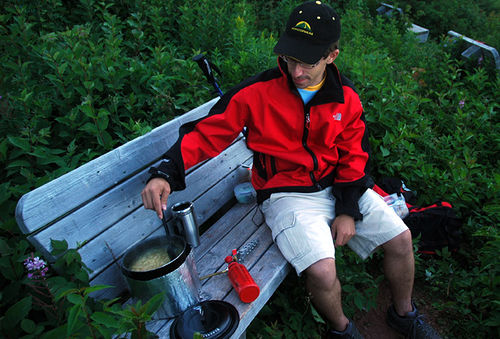

man in red jacket is sitting on bench whilst cooking meal
man is sitting on bench cooking some food
man sits on bench
man wearing red jacket is sitting on wooden bench and is cooking something in small pot
man wearing red jacket sitting on bench next to various camping items



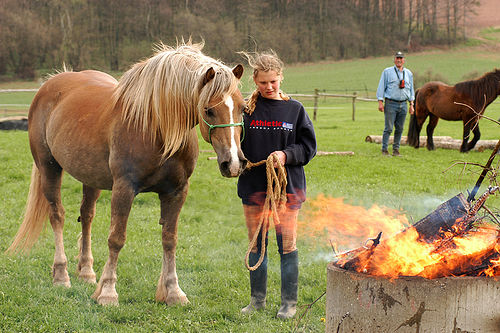

blonde horse and blonde girl in black sweatshirt are staring at fire in barrel
girl and her horse stand by fire
girl holding horse lead behind fire
man and girl and two horses are near contained fire
two people and two horses watching fire



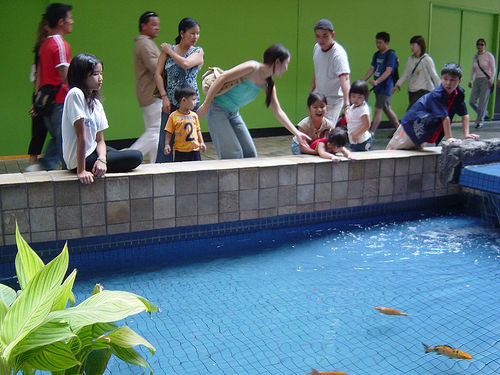

children sit and watch the fish moving in the pond
people stare at the orange fish
several people are standing near fish pond
some children watching fish in pool
there are several people and children looking into water with blue tiled floor and goldfish



In [ ]:
from PIL import Image

image = Image.open('/content/Flicker8k_Dataset/35506150_cbdb630f4f.jpg')
display(image)
liste = descriptions['35506150_cbdb630f4f']
print ('\n'.join(liste))
print()

image = Image.open('/content/Flicker8k_Dataset/10815824_2997e03d76.jpg')
display(image)
liste =  descriptions['10815824_2997e03d76']
print ('\n'.join(liste))
print()

image = Image.open('/content/Flicker8k_Dataset/12830823_87d2654e31.jpg')
display(image)
liste =  descriptions['12830823_87d2654e31']
print ('\n'.join(liste))
print()


In [ ]:
from numpy import array
from pickle import load
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.utils import plot_model
from keras.models import Model
from keras.layers import Input
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Embedding
from keras.layers import Dropout
from keras.layers.merge import add
from keras.callbacks import ModelCheckpoint

def load_doc(filename):
	file = open(filename, 'r')
	text = file.read()
	file.close()
	return text

def load_set(filename):
	doc = load_doc(filename)
	dataset = list()
	for line in doc.split('\n'):
		if len(line) < 1:
			continue
		identifier = line.split('.')[0]
		dataset.append(identifier)
	return set(dataset)

def load_clean_descriptions(filename, dataset):
	doc = load_doc(filename)
	descriptions = dict()
	for line in doc.split('\n'):
		tokens = line.split()
		image_id, image_desc = tokens[0], tokens[1:]
		if image_id in dataset:
			if image_id not in descriptions:
				descriptions[image_id] = list()
			desc = 'startseq ' + ' '.join(image_desc) + ' endseq'
			descriptions[image_id].append(desc)
	return descriptions

def load_photo_features(filename, dataset):
	all_features = load(open(filename, 'rb'))
	features = {k: all_features[k] for k in dataset}
	return features

def to_lines(descriptions):
	all_desc = list()
	for key in descriptions.keys():
		[all_desc.append(d) for d in descriptions[key]]
	return all_desc

def create_tokenizer(descriptions):
	lines = to_lines(descriptions)
	tokenizer = Tokenizer()
	tokenizer.fit_on_texts(lines)
	return tokenizer

def max_length(descriptions):
	lines = to_lines(descriptions)
	return max(len(d.split()) for d in lines)

def create_sequences(tokenizer, max_length, desc_list, photo, vocab_size):
	X1, X2, y = list(), list(), list()
	for desc in desc_list:
		seq = tokenizer.texts_to_sequences([desc])[0]
		for i in range(1, len(seq)):
			in_seq, out_seq = seq[:i], seq[i]
			in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
			out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
			X1.append(photo)
			X2.append(in_seq)
			y.append(out_seq)
	return array(X1), array(X2), array(y)

def define_model(vocab_size, max_length):
	inputs1 = Input(shape=(1000,))
	fe1 = Dropout(0.5)(inputs1)
	fe2 = Dense(256, activation='relu')(fe1)
	inputs2 = Input(shape=(max_length,))
	se1 = Embedding(vocab_size, 256, mask_zero=True)(inputs2)
	se2 = Dropout(0.5)(se1)
	se3 = LSTM(256)(se2)
	decoder1 = add([fe2, se3])
	decoder2 = Dense(256, activation='relu')(decoder1)
	outputs = Dense(vocab_size, activation='softmax')(decoder2)
	model = Model(inputs=[inputs1, inputs2], outputs=outputs)
	model.compile(loss='categorical_crossentropy', optimizer='adam')
	model.summary()
	plot_model(model, to_file='model.png', show_shapes=True)
	return model

def data_generator(descriptions, photos, tokenizer, max_length, vocab_size):
	while 1:
		for key, desc_list in descriptions.items():
			photo = photos[key][0]
			in_img, in_seq, out_word = create_sequences(tokenizer, max_length, desc_list, photo, vocab_size)
			yield [in_img, in_seq], out_word

filename = '/content/Flickr_8k.trainImages.txt'
train = load_set(filename)
print('Dataset: %d' % len(train))

train_descriptions = load_clean_descriptions('descriptions.txt', train)
print('Descriptions: train=%d' % len(train_descriptions))

train_features = load_photo_features('features.pkl', train)
print('Photos: train=%d' % len(train_features))

tokenizer = create_tokenizer(train_descriptions)
'''
tokenizer.word_index = {'startseq': 1, 'endseq': 2, 'in': 3, 'the': 4, 'on': 5, 'is': 6, 'and': 7,
                        'dog': 8, 'with': 9, 'man': 10, 'of': 11, 'two': 12, 'white': 13,  .... and so on,
'''
vocab_size = len(tokenizer.word_index) + 1

print('Vocabulary Size: %d' % vocab_size)

max_length = max_length(train_descriptions)
print('Description Length: %d' % max_length)

model = define_model(vocab_size, max_length)

epochs = 10
steps = len(train_descriptions)
print(steps)
for i in range(epochs):
    generator = data_generator(train_descriptions, train_features, tokenizer, max_length, vocab_size)
    model.fit_generator(generator, epochs=1, steps_per_epoch=steps, verbose=1)
    model.save('model_' + str(i) + '.h5')
    print(" ",i," ")

Dataset: 6000
Descriptions: train=6000
Photos: train=6000
Vocabulary Size: 7579
Description Length: 34
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 34)]         0           []                               
                                                                                                  
 input_1 (InputLayer)           [(None, 1000)]       0           []                               
                                                                                                  
 embedding (Embedding)          (None, 34, 256)      1940224     ['input_2[0][0]']                
                                                                                                  
 dropout (Dropout)              (None, 1000)         0           ['input_1[0][0]']        

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:131: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.


6000/6000 [==============================] - 1912s 318ms/step - loss: 4.6572
  0  
6000/6000 [==============================] - 1932s 322ms/step - loss: 3.8394
  1  
6000/6000 [==============================] - 1950s 325ms/step - loss: 3.5425
  2  
6000/6000 [==============================] - 1945s 324ms/step - loss: 3.3565
  3  
6000/6000 [==============================] - 1956s 326ms/step - loss: 3.2222
  4  
6000/6000 [==============================] - 1999s 333ms/step - loss: 3.1163
  5  
6000/6000 [==============================] - 2021s 337ms/step - loss: 3.0341
  6  
6000/6000 [==============================] - 2078s 346ms/step - loss: 2.9657
  7  
6000/6000 [==============================] - 2041s 340ms/step - loss: 2.9104
  8  
6000/6000 [==============================] - 2049s 342ms/step - loss: 2.8556
  9  


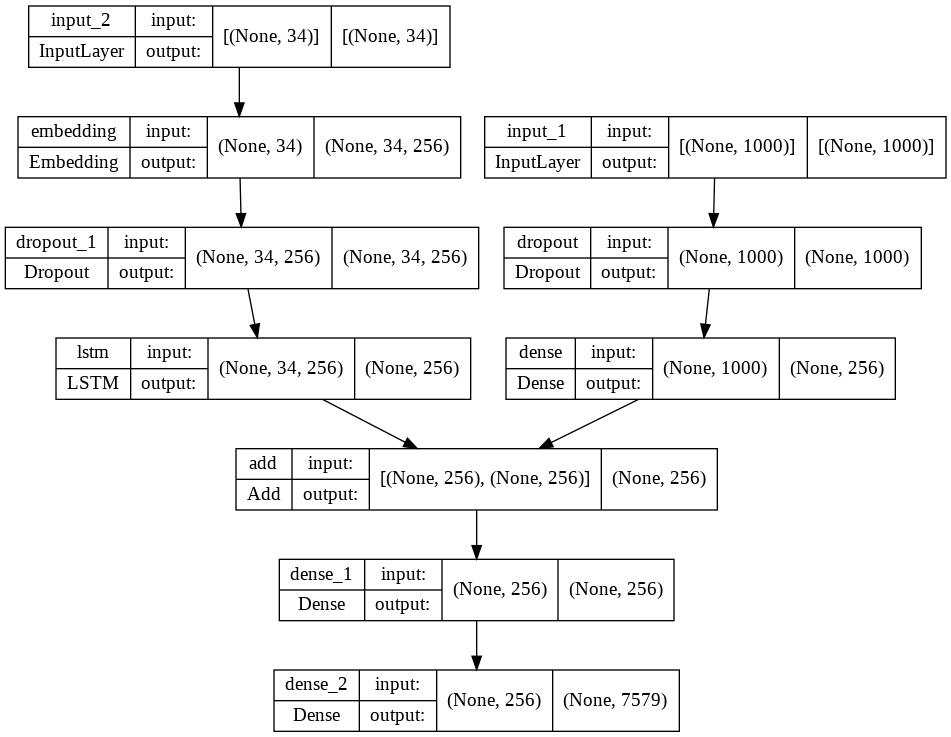

In [ ]:
image = Image.open('/content/model.png')
display(image)

In [ ]:
print(train_features['2513260012_03d33305cf'].shape)

(1, 1000)


In [ ]:
dump(tokenizer, open('tokenizer.pkl', 'wb'))

In [ ]:
import numpy

def word_for_id(integer, tokenizer):
	for word, index in tokenizer.word_index.items():
		if index == integer:
			return word
	return None

def generate_desc(model, tokenizer, photo, max_length):

	in_text = 'startseq'
	for i in range(max_length):

		sequence = tokenizer.texts_to_sequences([in_text])[0]
		sequence = pad_sequences([sequence], maxlen=max_length)
		yhat = model.predict([photo,sequence], verbose=0)
		yhat = numpy.argmax(yhat)
		word = word_for_id(yhat, tokenizer)
		if word is None:
			break
		in_text += ' ' + word
		if word == 'endseq':
			break
	return in_text

In [ ]:
from keras.models import load_model
tokenizer = load(open('tokenizer.pkl', 'rb'))
max_length = 34
# OUR SAVED MODEL
model = load_model('model_9.h5')

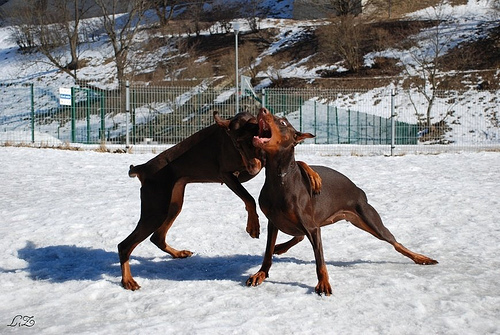


two dogs play in the water



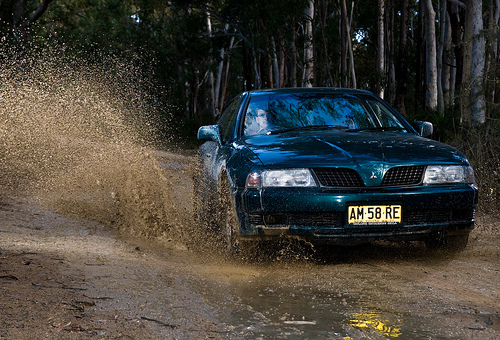


two people are riding bicycles on dirt road



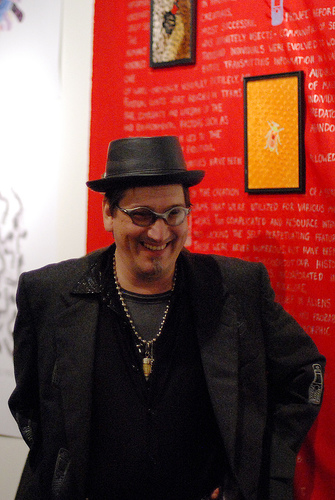


man in black shirt and sunglasses is sitting on bench



In [ ]:
from PIL import Image
def extract_feature(filename):
    model = VGG16()
    model.layers.pop()
    model = Model(inputs=model.inputs, outputs=model.layers[-1].output)
    image = load_img(filename, target_size=(224, 224))
    image = img_to_array(image)
    image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
    image = preprocess_input(image)
    feature = model.predict(image, verbose=0)
    return feature

filename = '/content/Flicker8k_Dataset/3385593926_d3e9c21170.jpg'
filename2 = '/content/Flicker8k_Dataset/2943023421_e297f05e11.jpg'
filename3 = '/content/Flicker8k_Dataset/2167644298_100ca79f54.jpg'

def imageCaption(filename):
    image = Image.open(filename)
    display(image)
    print()
    photo = extract_feature(filename)
    description = generate_desc(model, tokenizer, photo, max_length)
    description = description[len("startseq "):-len(" endseq")]
    print(description)
    print()

imageCaption(filename)
imageCaption(filename2)
imageCaption(filename3)

## ⛺ PROCESS FOR EVALUTING THE TEST IMAGES ⛺

1) We upload all Test Images which are not used any training and validation. (1000 Images for testing)

2) And get all features of images.

3) Get Description of Images for Comparing the results.

4) Generate new Captions using out LSTM model and photos features together.




In [ ]:
filename = '/content/Flickr_8k.testImages.txt'
test = load_set(filename)
print('Dataset: %d' % len(test))

test_descriptions = load_clean_descriptions('descriptions.txt', test)
print('Descriptions: test=%d' % len(test_descriptions))

test_features = load_photo_features('features.pkl', test)
print('Photos: test=%d' % len(test_features))

Dataset: 1000
Descriptions: test=1000
Photos: test=1000


In [ ]:
from nltk.translate.bleu_score import corpus_bleu

def evaluate_model(model, descriptions, photos, tokenizer, max_length):
	actual, predicted = list(), list()

	for key, desc_list in descriptions.items():

		yhat = generate_desc(model, tokenizer, photos[key], max_length)

		references = [d.split() for d in desc_list]
		actual.append(references)
		predicted.append(yhat.split())

	print('BLEU-1: %f' % corpus_bleu(actual, predicted, weights=(1.0, 0, 0, 0)))
	print('BLEU-2: %f' % corpus_bleu(actual, predicted, weights=(0.5, 0.5, 0, 0)))
	print('BLEU-3: %f' % corpus_bleu(actual, predicted, weights=(0.3, 0.3, 0.3, 0)))
	print('BLEU-4: %f' % corpus_bleu(actual, predicted, weights=(0.25, 0.25, 0.25, 0.25)))

BLEU value is between 0 to 1. If this value is closer to 1, it describes the image better.

In [ ]:
evaluate_model(model, test_descriptions, test_features, tokenizer, max_length)

BLEU-1: 0.536197
BLEU-2: 0.289443
BLEU-3: 0.202301
BLEU-4: 0.097427


In [ ]:
# test the data generator with progressive loading      batch size:47
generator = data_generator(train_descriptions, train_features, tokenizer, max_length, vocab_size)
inputs, outputs = next(generator)
print(inputs[0].shape)
print(inputs[1].shape)
print(outputs.shape)

(47, 1000)
(47, 34)
(47, 7579)


**REFERENCES**

https://machinelearningmastery.com/develop-a-deep-learning-caption-generation-model-in-python/

https://machinelearningmastery.com/prepare-photo-caption-dataset-training-deep-learning-model/

Show and Tell: A Neural Image Caption Generator:

https://ar5iv.labs.arxiv.org/html/1411.4555

